In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing important libraries**

In [83]:
# Common
import os 
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
from glob import glob
from tqdm import tqdm
from keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.layers import add
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import multiply
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Model
import glob,cv2
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Model Visualization
from keras.utils import plot_model
#from sklearn.model_selection import train_test_split
import os
import sys
import skimage.io
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
%matplotlib inline
import tensorflow as tf
from termcolor import colored


from pathlib import Path
import os
import glob 
import pandas as pd
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')


# **Reading Data**

In [48]:
trainData = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
testData = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
valData= '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [49]:
data_train = image_dataset_from_directory(trainData,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(valData,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(testData,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


**Normalize images (rescaling)**

In [50]:
IMG_SIZE = (256, 256)
train_datagen = ImageDataGenerator(rescale=1/255.0,rotation_range=45,shear_range=0.2,zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

In [51]:
train_dataset = train_datagen.flow_from_directory(trainData, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=200, 
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(testData, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(valData, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# **Visualising some images**

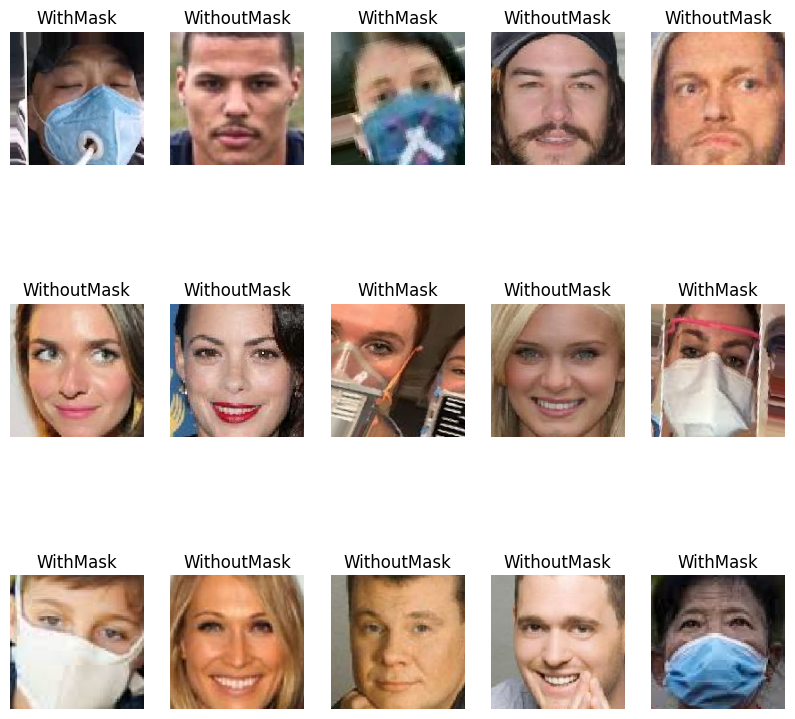

In [52]:
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')


# **Building Model**

 **Transfer Learning using mobilenetv2 model**

In [53]:
# Load MobileNetV2 model without top (fully connected) layers
BaseModel = MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in BaseModel.layers:
    layer.trainable = False

In [55]:
# model = Sequential()
# model.add(BaseModel)
# model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
 
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# Initialize the model in sequential
model = Sequential()
# add MobileNetV2 model into our sequence model
model.add(BaseModel)
# flatten the model
model.add(Flatten())
# Adding dense layers
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
# Adding output layer
model.add(Dense(2,activation='sigmoid'))

In [59]:
# # Create the final model
# model=Model(inputs=BaseModel.input,outputs=model)

In [60]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **Model visualization**

In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               10485888  
                                                                 
 dense_14 (Dense)            (None, 2)                 258       
                                                                 
Total params: 12,744,130
Trainable params: 10,486,146
Non-trainable params: 2,257,984
_________________________________________________________________


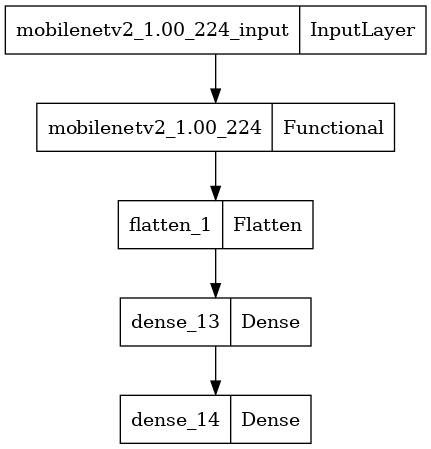

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# **Training Modle**

In [63]:
# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/10
50/50 [==============================] - 179s 4s/step - loss: 1.6045 - accuracy: 0.9163 - val_loss: 0.1446 - val_accuracy: 0.9650
Epoch 2/10
50/50 [==============================] - 172s 3s/step - loss: 0.0728 - accuracy: 0.9800 - val_loss: 0.0558 - val_accuracy: 0.9825
Epoch 3/10
50/50 [==============================] - 172s 3s/step - loss: 0.0414 - accuracy: 0.9854 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 4/10
50/50 [==============================] - 170s 3s/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.0295 - val_accuracy: 0.9887
Epoch 5/10
50/50 [==============================] - 170s 3s/step - loss: 0.0314 - accuracy: 0.9887 - val_loss: 0.0318 - val_accuracy: 0.9875
Epoch 6/10
50/50 [==============================] - 170s 3s/step - loss: 0.0287 - accuracy: 0.9895 - val_loss: 0.0455 - val_accuracy: 0.9850
Epoch 7/10
50/50 [==============================] - 170s 3s/step - loss: 0.0253 - accuracy: 0.9914 - val_loss: 0.0242 - val_accuracy: 0.9900
Epoch 8/10
50

# **Evaluating Model**

In [64]:
model.evaluate(validation_dataset)

13/13 [==============================] - 13s 968ms/step - loss: 0.0287 - accuracy: 0.9912


[0.0287078395485878, 0.9912499785423279]

# **Plotting Accuraccy and Loss**

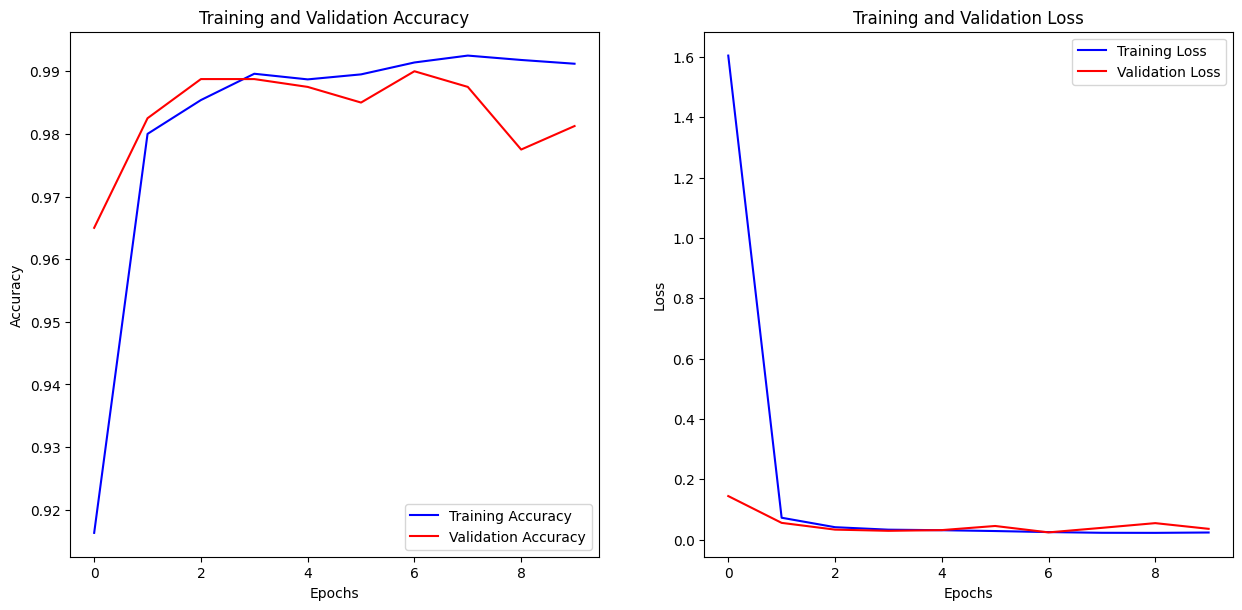

In [67]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, "b-", label='Training Accuracy')
plt.plot(epochs_range, val_acc, "r-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, "b-", label='Training Loss')
plt.plot(epochs_range, val_loss, "r-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# **Model Evaluation**

In [68]:
test_pred = model.predict(test_dataset)

16/16 [==============================] - 10s 607ms/step


In [69]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

1    509
0    483
Name: count, dtype: int64


In [74]:
def preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print('            ', colored(classes_train[res], "green"))

1/1 [==============================] - 0s 26ms/step
             WithoutMask


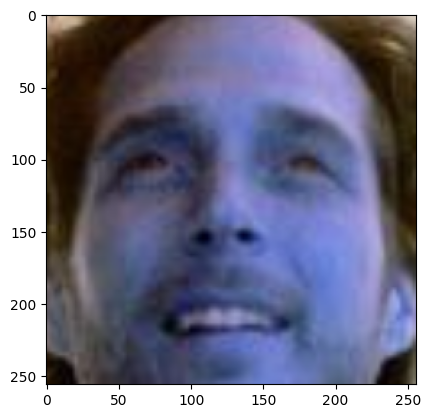

In [81]:
preprocessing('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1376.png')

1/1 [==============================] - 0s 29ms/step
             WithMask


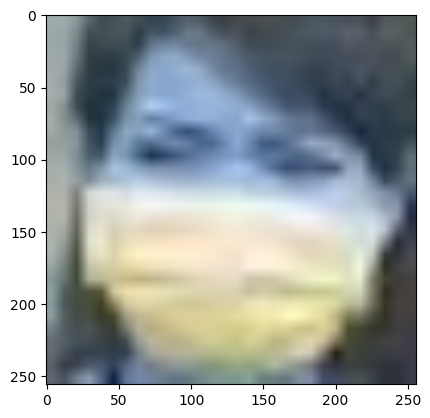

In [78]:
preprocessing('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1363.png')

In [86]:
datatest=Path(testData)
filepaths = list(datatest.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,../input/face-mask-12k-images-dataset/Face Mas...,WithMask
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask
2,../input/face-mask-12k-images-dataset/Face Mas...,WithMask


# **Saving Model**

In [87]:
model.save("FaceMaskDetector.model", save_format="h5")